In [1]:
from torchvision.datasets import Cityscapes

In [50]:
import torchvision.transforms as transforms

# Define the transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Resize((256,256),antialias=True)
])
dataset_path = 'C:\\Users\\jakub\\Desktop\\TUe\\AIES\\Q3\\5LSM0-Neural-networks-for-computer-vision\\FinalAssignment\\archive'

# Create the untransformed dataset
original_dataset = Cityscapes(dataset_path, split='train', mode='fine', target_type='semantic', transform=None, target_transform=None)

# Create transformed dataset
dataset = Cityscapes(dataset_path, split='train', mode='fine', target_type='semantic', transform=data_transforms, target_transform=data_transforms)

In [77]:
# Extract info about the original dataset
num_images_original = len(original_dataset)
image_original, _ = original_dataset[0]
image_size_original = image_original.width, image_original.height
num_classes_original = original_dataset.classes

# Extract info about the transformed dataset
num_images = len(dataset)
image_size = dataset[0][0].size()
num_classes = dataset.classes

# Create and open a text file
with open('dataset_info.txt', 'w') as file:
    # Original/untransformed dataset info
    file.write("Dataset state after transform:\n")
    file.write(f"Number of images: {num_images_original}\n")
    file.write(f"Image size: {image_size_original}\n")
    file.write(f"Number of classes: {num_classes_original}\n")
    # Dataset info AFTER applying the transforms
    file.write("\n")
    file.write("Dataset state after transform:\n")
    file.write(f"Number of images: {num_images}\n")
    file.write(f"Image size: {image_size}\n")
    file.write(f"Number of classes: {num_classes}\n")

print("Dataset state BEFORE transform:\n")
print("Number of samples:", len(original_dataset))
print("Classes:", original_dataset.classes)
print("Image size after applying transforms:", image_size_original, "\n")
print("Dataset info AFTER applying the transforms:\n")
print("Number of samples:", len(dataset))
print("Classes:", dataset.classes)
print("Image size after applying transforms:", image_size)



Dataset state BEFORE transform:

Number of samples: 2975
Classes: [CityscapesClass(name='unlabeled', id=0, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='ego vehicle', id=1, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='rectification border', id=2, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='out of roi', id=3, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='static', id=4, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='dynamic', id=5, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(111, 74, 0)), CityscapesClass(name='ground', id=6, train_id

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


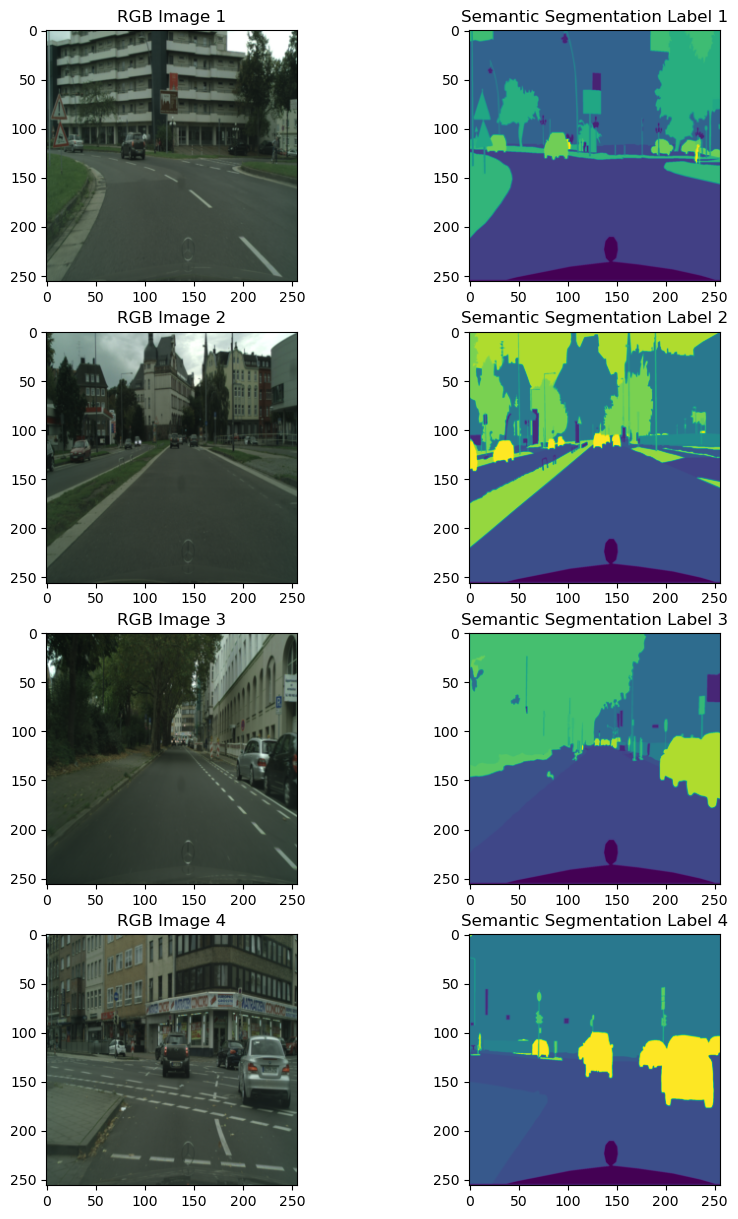

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for i in range(4):
    # TO DO: spec the fig size
    img, lbl = dataset[i]

    img_np = img.permute(1, 2, 0)
    lbl_np = lbl.permute(1, 2, 0)

    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(img_np)
    plt.title(f'RGB Image {i+1}')

    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(lbl_np)  # Adjust the colormap as needed
    plt.title(f'Semantic Segmentation Label {i+1}')

# Adjust layout to prevent overlap
# plt.tight_layout()
    
# Save a figure to a PNG format file
plt.savefig('Cityspace-test-vis.png')

plt.show()

In [45]:
# Save a figure to a PNG format file
plt.savefig('Cityspace-test-vis.png')

<Figure size 640x480 with 0 Axes>